# **1. Importing Required Libraries**

## **i) Basic Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## **ii) Machine Learning Libraries**

In [2]:
# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

## **iii) Libraries for Imputation & Balancing**

In [3]:
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE

## **iv) Libraries for Explainability**

In [4]:
import shap
import joblib
import warnings
warnings.filterwarnings("ignore")

# **2. Load the Dataset**

In [5]:
df = pd.read_csv('/content/Pima_Indians_Diabetes_Database.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# **3. Preprocessing & Imputation**

## **3.1 Handle Invalid 0s**

In [6]:
# Replace biologically invalid 0s with NaNs
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

## **3.2 KNN Imputation**

In [7]:
# KNN Imputer for missing values
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

## **3.3 Feature-Target Split**

In [8]:
# Split features and target
X = df_imputed.drop('Outcome', axis=1)
y = df_imputed['Outcome']

## **3.4 Feature Scaling**

In [9]:
# Feature scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# **4. Exploratory Data Analysis**

## **4.1 Class Distribution**

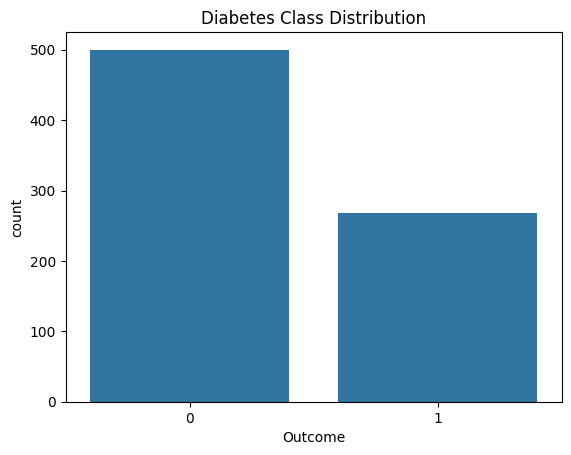

In [10]:
# Class distribution
sns.countplot(x='Outcome', data=df)
plt.title("Diabetes Class Distribution")
plt.show()

## **4.2 Feature Correlation**

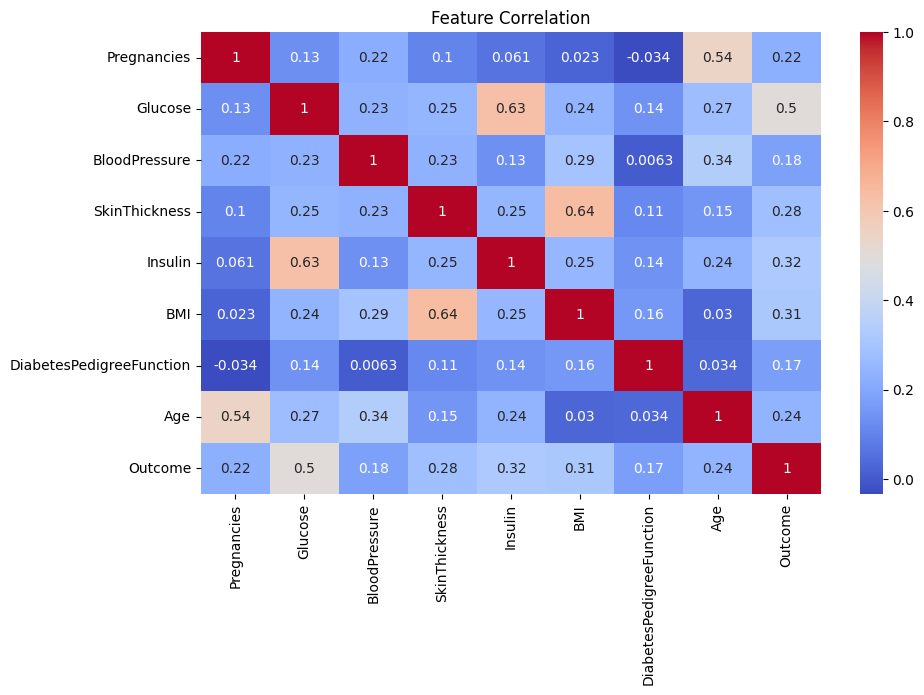

In [11]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

# **5. Train-Test Split & Balancing**

## **5.1 Split the Data**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

## **5.2 Apply SMOTE**

In [13]:
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# **6. Model Training & Testing**

Train and evaluate the following models:

------> Logistic Regression

------> Random Forest

------> KNN

------> SVM

------> Gradient Boosting

------> Neural Network (MLP)

Evaluation Metrics:

------> Accuracy

------> AUC Score

------> Classification Report

In [14]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n🔷 {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_proba))
    print("Classification Report:\n", classification_report(y_test, y_pred))


🔷 Logistic Regression
Accuracy: 0.7207792207792207
AUC: 0.8116666666666668
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.76      0.78       100
         1.0       0.59      0.65      0.62        54

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.73      0.72      0.72       154


🔷 Random Forest
Accuracy: 0.7467532467532467
AUC: 0.8151851851851852
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.77      0.80       100
         1.0       0.62      0.70      0.66        54

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154


🔷 KNN
Accuracy: 0.6688311688311688
AUC: 0.744537037037037
Classification Report:
               precision    recall  f1-score   support

         0.0  

# **7. ROC Curve Plotting**

------> Plot ROC curves for all models

------> Display AUC values on the graph

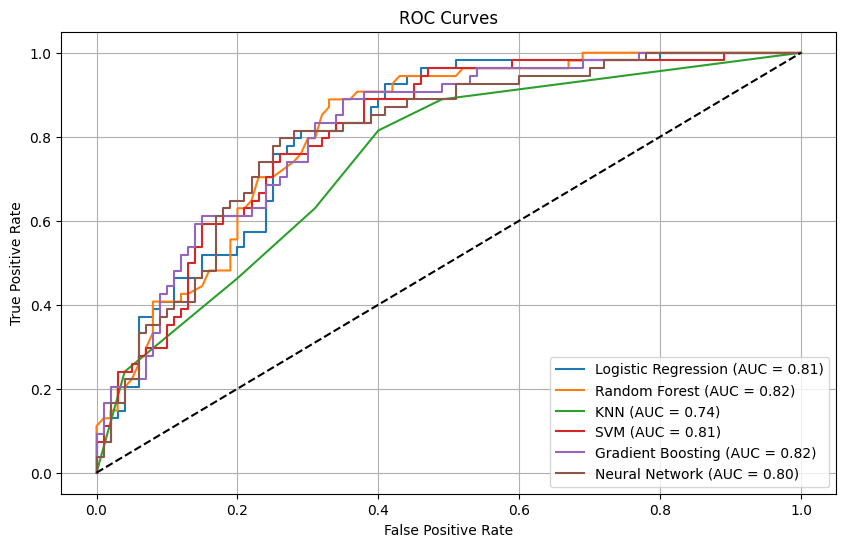

In [15]:
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# **8. SHAP Explainability (Global & Local)**

## **8.1 SHAP Explainer Initialization**

In [16]:
# Reconfirm best_model (already trained)
best_model = models["Random Forest"]

# Sample 100 rows from test set
sample_X = X_test.sample(n=100, random_state=42)

# Create explainer with training data (ensures tree structure is known)
explainer = shap.Explainer(best_model, X_train_res)

## **8.2 SHAP Value Computation**

In [17]:
# Get SHAP values for sampled test data
shap_values = explainer(sample_X, check_additivity=False)

# Select SHAP values only for class 1 (positive class)
# This gives a single-dimensional explanation per feature
shap_values_class1 = shap.Explanation(
    values=shap_values.values[:, :, 1],
    base_values=shap_values.base_values[:, 1],
    data=sample_X,
    feature_names=sample_X.columns
)

## **8.3 Beeswarm Plot**

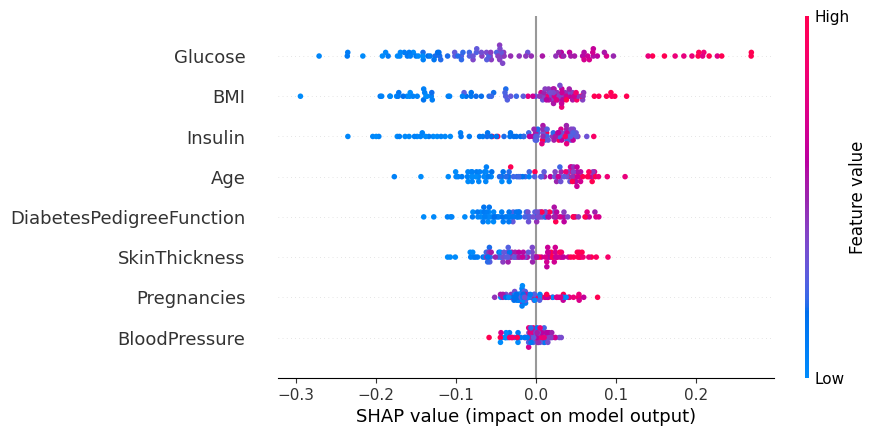

In [18]:
# Beeswarm summary plot
shap.plots.beeswarm(shap_values_class1)

## **8.4 Force Plot**

In [19]:
# Force plot for the first sample
shap.initjs()
shap.plots.force(shap_values_class1[0])

# **9. Save the Best Model**

In [20]:
joblib.dump(best_model, 'diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# **10. Grid Search for Random Forest**

## **10.1 Define Hyperparameter Grid**

In [21]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5],
}

## **10.2 Run GridSearchCV**

In [22]:
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_res, y_train_res)

# Best estimator
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


## **10.3 Evaluate Tuned Model**

In [23]:
# Evaluate
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("\n🔍 Random Forest (Tuned) Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))


🔍 Random Forest (Tuned) Results
Accuracy: 0.7337662337662337
AUC: 0.8135185185185185


# **11. Voting Classifier (Ensemble)**

------> Combine Logistic Regression, Tuned Random Forest, and SVM

------> Use soft voting

------> Evaluate ensemble model

In [24]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', best_rf),
        ('svm', SVC(probability=True))
    ],
    voting='soft'
)
voting_clf.fit(X_train_res, y_train_res)

y_pred_vote = voting_clf.predict(X_test)
y_proba_vote = voting_clf.predict_proba(X_test)[:, 1]

print("\n🧠 Voting Classifier Results")
print("Accuracy:", accuracy_score(y_test, y_pred_vote))
print("AUC:", roc_auc_score(y_test, y_proba_vote))


🧠 Voting Classifier Results
Accuracy: 0.7402597402597403
AUC: 0.8190740740740741


# **12. Cross-Validation (10-Fold AUC)**

------> Use StratifiedKFold with cross_val_score

------> Report individual and average AUC scores

In [25]:
cv_scores = cross_val_score(best_rf, X_scaled, y, cv=StratifiedKFold(n_splits=10), scoring='roc_auc')
print("\n🔂 10-Fold CV ROC AUC Scores:", cv_scores)
print("Mean ROC AUC:", np.mean(cv_scores))


🔂 10-Fold CV ROC AUC Scores: [0.80592593 0.8362963  0.84296296 0.73851852 0.83407407 0.86148148
 0.85259259 0.89037037 0.78384615 0.88230769]
Mean ROC AUC: 0.8328376068376068


# **13. Custom Model Evaluation Function**

**evaluate_model() function to:**

------> Print metrics

------> Plot ROC curve

**Use it to compare:**

------> Tuned Random Forest

------> Voting Classifier



In [26]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n📊 {name} Evaluation")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("AUC Score:", roc_auc_score(y_test, y_proba))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()


📊 Tuned Random Forest Evaluation
Accuracy: 0.7337662337662337
AUC Score: 0.8135185185185185
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.72      0.78       100
         1.0       0.59      0.76      0.67        54

    accuracy                           0.73       154
   macro avg       0.72      0.74      0.72       154
weighted avg       0.76      0.73      0.74       154



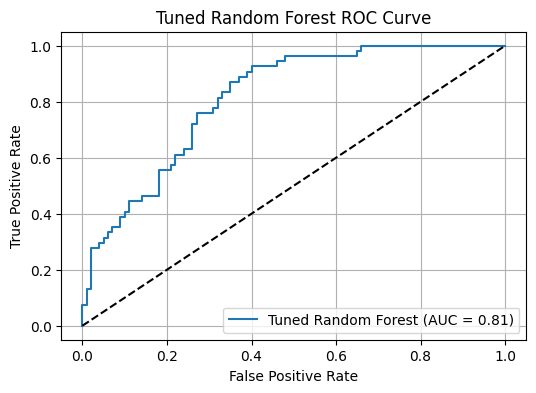

In [27]:
evaluate_model("Tuned Random Forest", best_rf, X_test, y_test)


📊 Voting Classifier Evaluation
Accuracy: 0.7402597402597403
AUC Score: 0.8190740740740741
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.76      0.79       100
         1.0       0.61      0.70      0.66        54

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.74      0.74       154



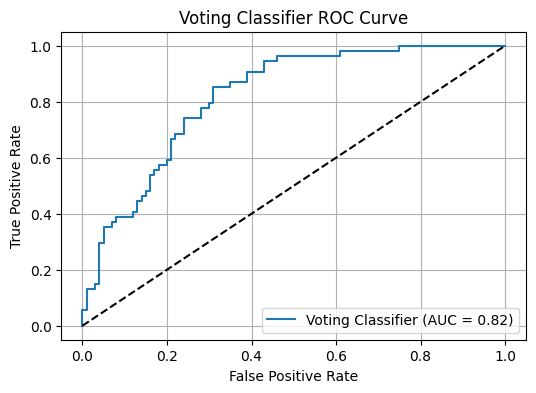

In [28]:
evaluate_model("Voting Classifier", voting_clf, X_test, y_test)